## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
 
from datetime import datetime, timedelta
from itertools import product
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Binary game Simulation

### Fixed-percent-betting simulation

In [2]:
def getSim_binaryFixPct(initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """
    Obtain dictionary of equal-percent-bet simulation results.
    initAmount: initial amount for betting
    f: percent per bet
    p: winning probability
    b: reward-to-risk ratio (/ odds)
    numTrialss: number of trials of the same binary game
    numSim: number of binary simulations
    """
    # Dict for recording different series of profit/loss
    simDict = {}
    # Dict for recording different series of capital (total equity)
    amountDict = {}
    # Generate a total of `numSim`= N series of binary game result and P/L
    stepFunc = lambda x: 1 if x > 0 else 0  # Lambda Function for getting "1" with a fixed prob and "0" otherwise
    for num in range(numSim):
        # Generate a series of "1"/"0" with probability p
        signArray = np.array([stepFunc(r) for r in np.random.uniform(p - 1, p, numTrials)])
        # Series of asset growth factor based on win/loss result (EITHER (1 + b * f%) OR (1 -f%))
        trialArray = 1 + f * ((b + 1) * signArray - 1) / 100
        # Record the asset growth factor series into `simDict`
        simDict[num + 1] = trialArray
        # Array of total equity and record into `amountDict`
        amountDict[f's{num + 1}'] = initAmount * trialArray.cumprod()
    # Form dataframe from the `amountDict` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(amountDict).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Performance KPIs: winning rate, RRR (Realized reward-risk ratio), profit factor

In [3]:
def getProfitfactor(p, b):
    """Get profit factor of a binary game."""
    return round(p * b / (1 - p), 4)

def getOdds(p, pf):
    """Given fixed winning rate and profit factor, find odds (or reward-risk ratio)."""
    return pf * (1 - p) / p

def getWinrate(b, pf):
    """Given fixed odds and profit factor, find winning rate."""   
    return pf / (pf + b)

### Sample of 20 fixed-percent-betting simulations of 12 trials

In [4]:
initAmount0 = 100  # Initial capital
f0 = 20  # Fixed amount per bet
p0 = 0.5   # winning probability
b0 = 1.6   # reward-risk ratio / odds
numTrials0 = 12 # Number of trials
numSim0 = 10  # Number of simulations (how many people keep playing same game for 12 runs)

pf0 = round(getProfitfactor(p0, b0), 4)
print(f'Profit Factor = {pf0}')

dfSim0 = np.round(getSim_binaryFixPct(initAmount0, f0, p0, b0, numTrials0, numSim0), 2)
dfSim0

Profit Factor = 1.6


1       2       3       4       5       6       7       8       9   \
s1    80.0  105.60  139.39  184.00  147.20  117.76   94.21   75.37   99.48   
s2    80.0  105.60  139.39  111.51   89.21  117.76  155.44  124.35   99.48   
s3    80.0  105.60   84.48   67.58   89.21  117.76   94.21  124.35  164.15   
s4   132.0  174.24  139.39  184.00  242.88  194.30  155.44  205.18  164.15   
s5    80.0   64.00   51.20   40.96   32.77   43.25   34.60   27.68   36.54   
s6   132.0  174.24  139.39  111.51   89.21   71.37   94.21   75.37   60.29   
s7    80.0   64.00   84.48   67.58   54.07   43.25   57.09   45.68   36.54   
s8    80.0   64.00   84.48   67.58   89.21  117.76   94.21   75.37   60.29   
s9   132.0  174.24  230.00  303.60  400.75  320.60  423.19  338.55  446.89   
s10   80.0  105.60   84.48  111.51  147.20  117.76  155.44  205.18  270.84   

         10      11      12  
s1   131.32  173.34  138.67  
s2    79.59  105.05  138.67  
s3   131.32  105.05   84.04  
s4   131.32  173.34  228.81  
s5    48.23   38.59   30.87  
s6    79.59   63.67   84.04  
s7    48.23   63.67   84.04  
s8    48.23   38.59   50.93  
s9   357.51  286.01  228.81  
s10  357.51  286.01  228.81

## Equity curve plotting

### Functions for simulation KPI & curve plotting

In [5]:
def getSimKPI_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = simFunc(initAmount, f, p, b, numTrials, numSim)
    dictKPI = {}
    dictKPI['p'] = p
    dictKPI['b'] = b
    dictKPI['f'] = f
    dictKPI['profitfactor'] = round(getProfitfactor(p, b), 4)
    dictKPI['win%'] = round(100 * dfSim[dfSim[numTrials] >= initAmount].shape[0] / numSim, 2)
    dictKPI['avgAmount'] = round(dfSim[numTrials].mean(), 2)
    dictKPI['midAmount'] = round(dfSim[numTrials].median(), 2)
    dictKPI['stdAmount'] = round(dfSim[numTrials].std(), 2)

    return dfSim, dictKPI

def plotSim_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400, semilog=True):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI_discretePL()` function
    dfSim, dictKPI = getSimKPI_discretePL(simFunc, initAmount, f, p, b, numTrials, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numTrials}-step binary game \n'
    if semilog:
        title += f'Winning rate {round(p, 4)}, odds {round(b, 4)}, {f}% per bet \n'
    else:
        title += f'Winning rate {round(p, 4)}, odds {round(b, 4)}, ${f} per bet \n'

    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    avgAmount = dictKPI['avgAmount']  # Arithmetic mean of final equity
    midAmount = dictKPI['midAmount']  # Median of final equity
    stdAmount = dictKPI['stdAmount']  # SD of final equity
    profitfactor = dictKPI['profitfactor']

    # Attach key stats to title text
    title += f'Profit factor: {profitfactor}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {avgAmount}, median: {midAmount}, SD: {stdAmount}'

    # Plot figure & append title
    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(title, fontsize=12)

    # Transpose the equity dataframe to plot
    dfPlot = dfSim.transpose()

    # Adopt semi-log scale for fixed-percent-betting & linear scale for fixed-amount-betting
    if semilog:
        plt.semilogy(dfPlot)
    else:
        plt.plot(dfPlot)
    plt.plot(dfPlot.index, np.repeat(initAmount, numTrials), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### KPI for standard sample: p = 0.4, b = 2.0

In [6]:
initAmount1 = 100  
f1 = 10  
p1 = 0.4   
b1 = 2.0   
numTrials1 = 50 
numSim1 = 1000  

dfSim1, dictKPI1 = getSimKPI_discretePL(getSim_binaryFixPct, initAmount1, f1, p1, b1,  numTrials1, numSim1)
dictKPI1

{'p': 0.4,
 'b': 2.0,
 'f': 10,
 'profitfactor': 1.3333,
 'win%': 66.3,
 'avgAmount': 261.13,
 'midAmount': 162.52,
 'stdAmount': 329.21}

### Curves of 1000 simulations of 50 trials

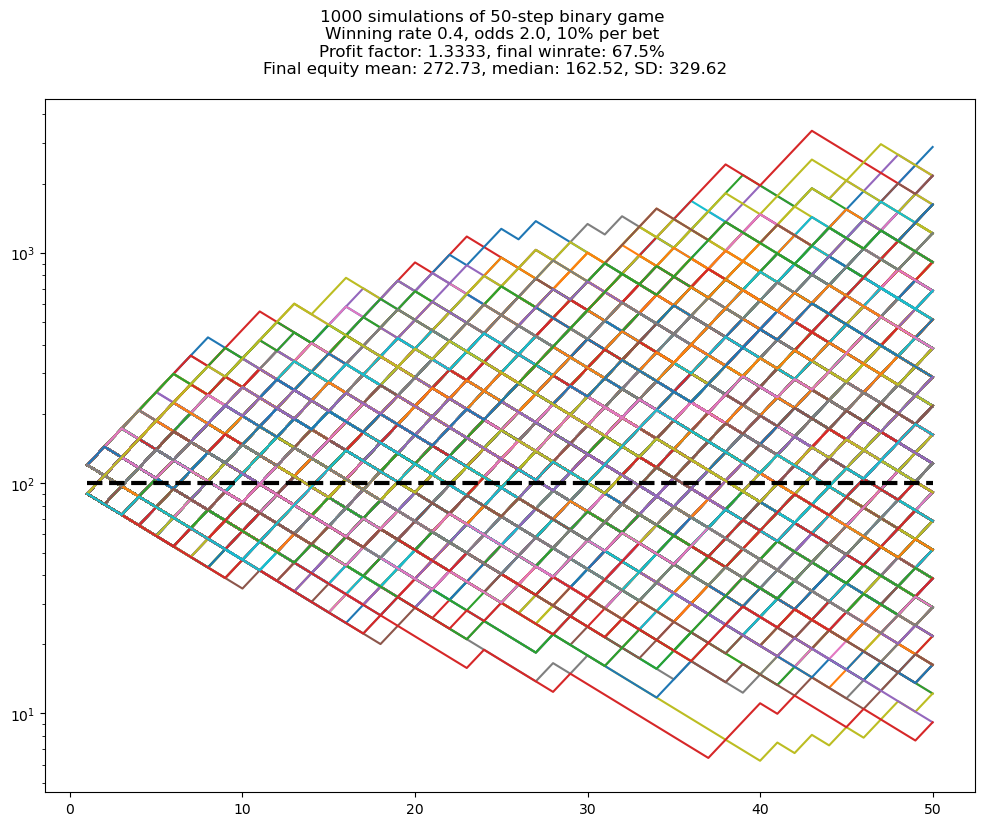

In [7]:
plotSim_discretePL(getSim_binaryFixPct, initAmount1, f1, p1, b1, numTrials1, numSim1)

### Raising winning rate & fix percent-per-bet, profit factor (odds reduced)

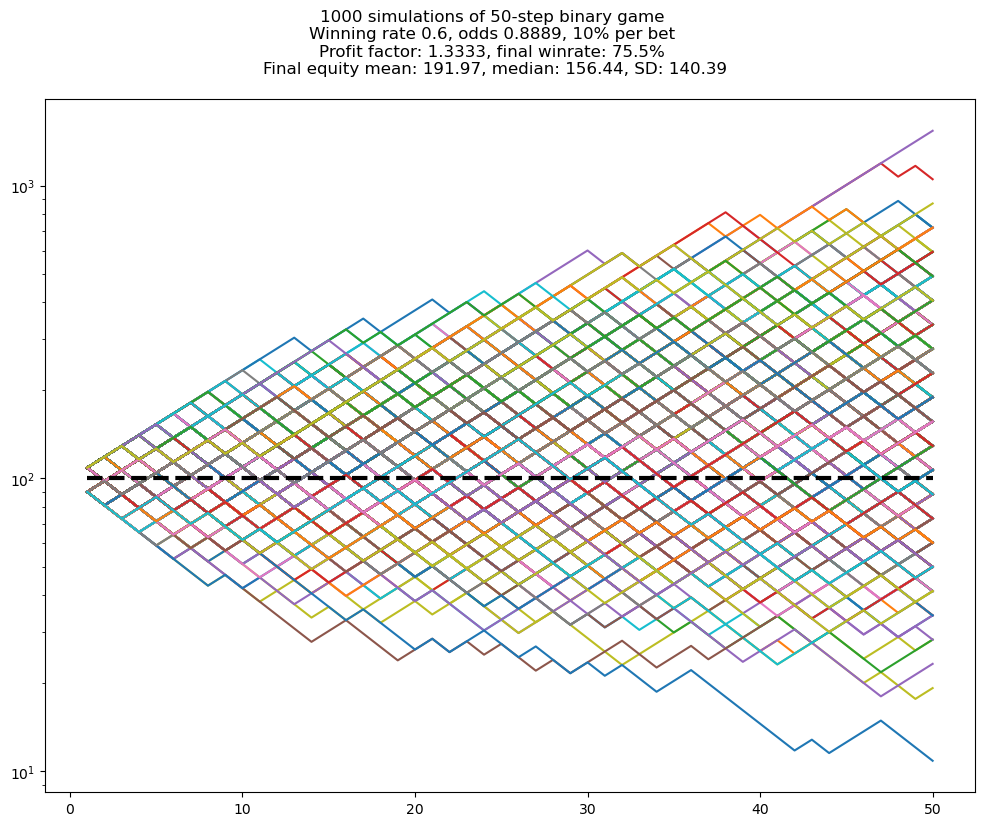

In [8]:
profitfactor1 = 4 / 3
p2 = 0.6   
b2 = getOdds(p2, profitfactor1)

plotSim_discretePL(getSim_binaryFixPct, initAmount1, f1, p2, b2, numTrials1, numSim1)

### Fix p & b, vary percent-per-bet

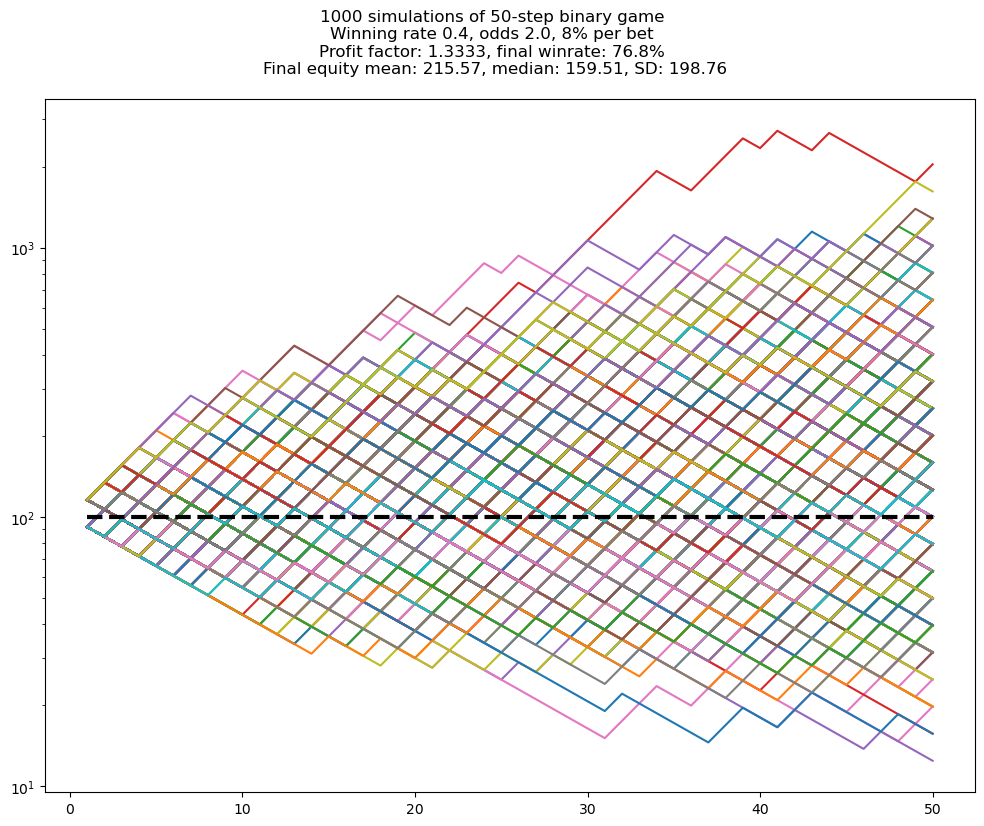

In [9]:
f2 = 8
plotSim_discretePL(getSim_binaryFixPct, initAmount1, f2, p1, b1, numTrials1, numSim1)

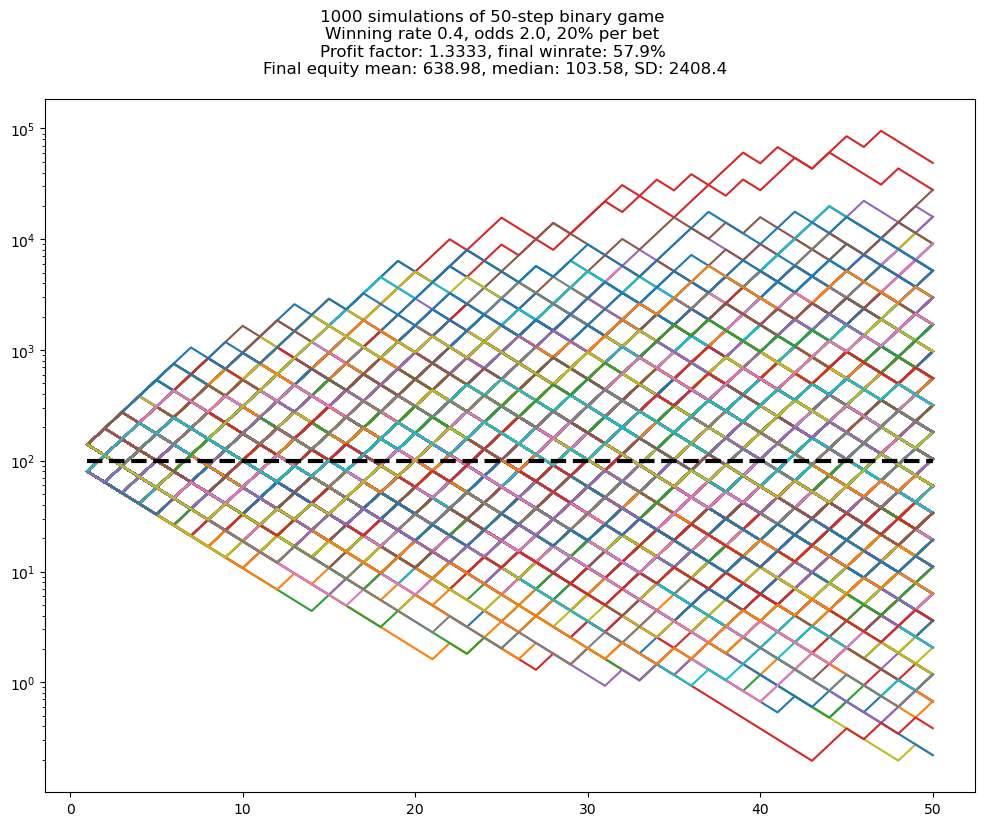

In [10]:
f3 = 20
plotSim_discretePL(getSim_binaryFixPct, initAmount1, f3, p1, b1, numTrials1, numSim1)

## Risk control & ruin

### Risk of ruin & MDD in a simulation

In [11]:
def getRuin(dfSim, initAmount=100, numTrial=50, level=0.1):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""   
    return dfSim[dfSim[numTrial] <= level*initAmount].shape[0] / dfSim.shape[0]

def getSimMDD(dfSim, levelsMDD=(0.2, 0.5, 0.8, 0.9)):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""
    # Transpose the simulation dataframe
    dfSimT = dfSim.transpose()
    numTrial = dfSim.shape[1]
    numSim = dfSim.shape[0]
    # Compute MDD
    dfMDD = pd.DataFrame(columns=dfSimT.columns)
    for col in dfSimT.columns:
        dfMDD[col] = (dfSimT[col] / dfSimT[col].cummax() - 1).cummin()
    # Tranpose back to match original shape
    dfMDD = dfMDD.transpose()
    # Compute percentage of simulations having MDD greater than the levels
    dictMDD = {}
    for value in levelsMDD:
        dictMDD[value] = dfMDD[dfMDD[numTrial] <= -value].shape[0] / numSim

    return dfMDD, dictMDD   

### Using above (p, b) pair and vary number of trials & ruin level

In [12]:
arrLevel = np.arange(0.05, 0.55, 0.05)  ## equity threshold level from 5% to 25%
arrTrials = range(50, 300, 50)  ## Number of betting trials from 50 to 250

dfRuin1 = pd.DataFrame(columns=arrTrials, index=arrLevel)

for numTrials, level in product(arrTrials, arrLevel):
    dfSim = getSim_binaryFixPct(initAmount1, f1, p1, b1, numTrials, numSim1)
    dfRuin1.loc[level, numTrials] = getRuin(dfSim, initAmount1, numTrials, level)

print(f'% of final equity below X% of initial for f = {f1}%: \n\n {dfRuin1}\n')

dfMDD1, dictMDD1 = getSimMDD(dfSim1)
print(f'Percentage of betting series suffering \n')

for key, value in dictMDD1.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

% of final equity below X% of initial for f = 10%: 

         50     100    150    200    250
0.05    0.0  0.001  0.005  0.002   0.01
0.10    0.0  0.009  0.009  0.014  0.012
0.15  0.005  0.024  0.033  0.033  0.023
0.20  0.016  0.049  0.041  0.035  0.029
0.25  0.023  0.049  0.052  0.054  0.034
0.30   0.07  0.059  0.056  0.076  0.052
0.35  0.046  0.062  0.086  0.062  0.057
0.40  0.099  0.098  0.079  0.088  0.069
0.45  0.071  0.094  0.104  0.079  0.072
0.50  0.081  0.135  0.094  0.078  0.083

Percentage of betting series suffering 

20% MDD: 100.0%
50% MDD: 65.4%
80% MDD: 4.4%
90% MDD: 0.4%


### Fix p, b and raise f to 20%

In [13]:
dfSim2, dictKPI2 = getSimKPI_discretePL(getSim_binaryFixPct, initAmount1, f3, p1, b1, numTrials1, numSim1)
for key, value in dictKPI2.items():
    print(f'{key}: {value}')

dfRuin2 = pd.DataFrame(columns=arrTrials, index=arrLevel)

for numTrials, level in product(arrTrials, arrLevel):
    dfSim = getSim_binaryFixPct(initAmount1, f3, p1, b1, numTrials, numSim1)
    dfRuin2.loc[level, numTrials] = getRuin(dfSim, initAmount1, numTrials, level)

print(f'\nPercentage of final equity below X% of initial for f = {f1}%: \n\n {dfRuin2}')

dfMDD2, dictMDD2 = getSimMDD(dfSim2)

print(f'\nPercentage of betting series suffering \n')

for key, value in dictMDD2.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

p: 0.4
b: 2.0
f: 20
profitfactor: 1.3333
win%: 57.0
avgAmount: 726.84
midAmount: 103.58
stdAmount: 2879.18

Percentage of final equity below X% of initial for f = 10%: 

         50     100    150    200    250
0.05  0.054  0.129  0.185  0.203  0.238
0.10  0.094  0.167  0.219  0.247  0.287
0.15  0.161  0.252  0.274  0.325  0.324
0.20  0.249  0.231    0.3  0.286  0.306
0.25  0.253  0.317  0.326  0.383  0.382
0.30  0.232    0.3  0.384  0.357  0.379
0.35  0.345  0.289  0.373   0.37  0.373
0.40  0.342  0.348  0.411  0.409  0.442
0.45  0.349  0.398  0.366    0.4  0.411
0.50  0.317  0.387  0.396  0.433  0.416

Percentage of betting series suffering 

20% MDD: 100.0%
50% MDD: 98.6%
80% MDD: 63.8%
90% MDD: 35.2%


## Optimal f% / Kelly Formula

### Expected geometric growth (= 1 + percentage-return)

In [14]:
def getExpGrowth(p=0.5, b=1.5, f=0.1, n=1):
    """
    Obtain expected geometric return of repeated trials of a binary game.
    p: winning rate
    b: odds / reward-risk-ratio
    f: fixed percent of each bet
    n: number of trials
    """
    logGrowth = p * np.log(1 + b * f) + (1 - p) * np.log(1 - f)
    
    return np.exp(n * logGrowth)

def plotExpGrowth(p=0.5, b=1.5, n=1, fMin=0, fMax=0.5, step=0.01):
    """Plot expected geometric growth given fixed winning rate & odds, and identify optimal f%."""
    # Form pandas Series of expected return of varying f%
    arrFpct = np.arange(fMin, fMax, step)
    dictGrowth = {f: getExpGrowth(p, b, f, n) - 1 for f in arrFpct}
    dfGrowth = pd.DataFrame(pd.Series(dictGrowth))
    # Plot interactive diagram of f-percent curve
    fig = px.line(x=dfGrowth.index, y=dfGrowth[0], labels={'x': 'f%', 'y': f'%return on {n} trials'})
    fig.add_trace(go.Scatter(x=dfGrowth.index, y=np.repeat(0, len(arrFpct)), name='0%'))
    # Identify optimal f%
    bestF = dfGrowth[0].idxmax()
    bestGrowth = dfGrowth[0].max()
    fig.add_trace(go.Scatter(x=(bestF, ), y=(bestGrowth, ), line_color='green', name='Opt-f%', mode='markers+text', 
                             marker_size=10, text=f'{bestF, round(bestGrowth, 4)}', textposition='bottom center'))
    
    # Show diagram
    fig.show()

### Example 1 (adopt above example p1 = 0.4, b1 = 2.0)

In [15]:
plotExpGrowth(p1, b1, n=50)

### Example 2 (Fix b = 2.0, improve p to 0.5, and reduce to 10 trials)

In [16]:
p4 = 0.5
b4 = 2.0
plotExpGrowth(p4, b4, n=10)

### Example 3 (Fix profit factor in eg.1 [4 / 3] and raise p to 0.6)

In [17]:
b2 = getOdds(p2, profitfactor1)
plotExpGrowth(p2, b2, n=50)

### Kelly formula (for discrete binary game ONLY)

In [18]:
def getKellyF(p, b):
    """Obtain the optimal f% by Kelly formula."""
    return round(max((p * b - 1 + p) / b, 0), 4)

### Kelly f% value for a bunch of (p, b) pair

In [19]:
arrP = np.arange(0.2, 0.85, 0.05)
arrB = np.arange(0.5, 4.25, 0.25)

dfKelly = pd.DataFrame()

for p, b in product(arrP, arrB):
    dfKelly.loc[b, f'{round(100*p, 2)}%'] = f'{round(100 * getKellyF(p, b), 2)}%'

dfKelly

20.0%  25.0%   30.0%   35.0%   40.0%   45.0%   50.0%   55.0%   60.0%  \
0.50    0%     0%      0%      0%      0%      0%      0%      0%      0%   
0.75    0%     0%      0%      0%      0%      0%      0%      0%   6.67%   
1.00    0%     0%      0%      0%      0%      0%      0%   10.0%   20.0%   
1.25    0%     0%      0%      0%      0%    1.0%   10.0%   19.0%   28.0%   
1.50    0%     0%      0%      0%      0%   8.33%  16.67%   25.0%  33.33%   
1.75    0%     0%      0%      0%   5.71%  13.57%  21.43%  29.29%  37.14%   
2.00    0%     0%      0%    2.5%   10.0%   17.5%   25.0%   32.5%   40.0%   
2.25    0%     0%      0%   6.11%  13.33%  20.56%  27.78%   35.0%  42.22%   
2.50    0%     0%    2.0%    9.0%   16.0%   23.0%   30.0%   37.0%   44.0%   
2.75    0%     0%   4.55%  11.36%  18.18%   25.0%  31.82%  38.64%  45.45%   
3.00    0%   0.0%   6.67%  13.33%   20.0%  26.67%  33.33%   40.0%  46.67%   
3.25    0%  1.92%   8.46%   15.0%  21.54%  28.08%  34.62%  41.15%  47.69%   
3.50    0%  3.57%   10.0%  16.43%  22.86%  29.29%  35.71%  42.14%  48.57%   
3.75    0%   5.0%  11.33%  17.67%   24.0%  30.33%  36.67%   43.0%  49.33%   
4.00  0.0%  6.25%   12.5%  18.75%   25.0%  31.25%   37.5%  43.75%   50.0%   

       65.0%   70.0%   75.0%   80.0%  
0.50      0%   10.0%   25.0%   40.0%  
0.75  18.33%   30.0%  41.67%  53.33%  
1.00   30.0%   40.0%   50.0%   60.0%  
1.25   37.0%   46.0%   55.0%   64.0%  
1.50  41.67%   50.0%  58.33%  66.67%  
1.75   45.0%  52.86%  60.71%  68.57%  
2.00   47.5%   55.0%   62.5%   70.0%  
2.25  49.44%  56.67%  63.89%  71.11%  
2.50   51.0%   58.0%   65.0%   72.0%  
2.75  52.27%  59.09%  65.91%  72.73%  
3.00  53.33%   60.0%  66.67%  73.33%  
3.25  54.23%  60.77%  67.31%  73.85%  
3.50   55.0%  61.43%  67.86%  74.29%  
3.75  55.67%   62.0%  68.33%  74.67%  
4.00  56.25%   62.5%  68.75%   75.0%

### Profit factor corresponding to above (p, b) pairs

In [20]:
dfProfitfactor = pd.DataFrame()

for p, b in product(arrP, arrB):
    dfProfitfactor.loc[b, f'{round(100*p, 2)}%'] = float(f'{round(getProfitfactor(p, b), 2)}')

dfProfitfactor

20.0%  25.0%  30.0%  35.0%  40.0%  45.0%  50.0%  55.0%  60.0%  65.0%  \
0.50   0.12   0.17   0.21   0.27   0.33   0.41   0.50   0.61   0.75   0.93   
0.75   0.19   0.25   0.32   0.40   0.50   0.61   0.75   0.92   1.12   1.39   
1.00   0.25   0.33   0.43   0.54   0.67   0.82   1.00   1.22   1.50   1.86   
1.25   0.31   0.42   0.54   0.67   0.83   1.02   1.25   1.53   1.88   2.32   
1.50   0.38   0.50   0.64   0.81   1.00   1.23   1.50   1.83   2.25   2.79   
1.75   0.44   0.58   0.75   0.94   1.17   1.43   1.75   2.14   2.62   3.25   
2.00   0.50   0.67   0.86   1.08   1.33   1.64   2.00   2.44   3.00   3.71   
2.25   0.56   0.75   0.96   1.21   1.50   1.84   2.25   2.75   3.38   4.18   
2.50   0.62   0.83   1.07   1.35   1.67   2.05   2.50   3.06   3.75   4.64   
2.75   0.69   0.92   1.18   1.48   1.83   2.25   2.75   3.36   4.12   5.11   
3.00   0.75   1.00   1.29   1.62   2.00   2.45   3.00   3.67   4.50   5.57   
3.25   0.81   1.08   1.39   1.75   2.17   2.66   3.25   3.97   4.88   6.04   
3.50   0.88   1.17   1.50   1.88   2.33   2.86   3.50   4.28   5.25   6.50   
3.75   0.94   1.25   1.61   2.02   2.50   3.07   3.75   4.58   5.62   6.96   
4.00   1.00   1.33   1.71   2.15   2.67   3.27   4.00   4.89   6.00   7.43   

      70.0%  75.0%  80.0%  
0.50   1.17   1.50    2.0  
0.75   1.75   2.25    3.0  
1.00   2.33   3.00    4.0  
1.25   2.92   3.75    5.0  
1.50   3.50   4.50    6.0  
1.75   4.08   5.25    7.0  
2.00   4.67   6.00    8.0  
2.25   5.25   6.75    9.0  
2.50   5.83   7.50   10.0  
2.75   6.42   8.25   11.0  
3.00   7.00   9.00   12.0  
3.25   7.58   9.75   13.0  
3.50   8.17  10.50   14.0  
3.75   8.75  11.25   15.0  
4.00   9.33  12.00   16.0

### Expected growth using kelly-f%, half-kelly and 2x-kelly

- Frequency inversely proportional to profit factor (trichotomy of win%, odds & frequency)

In [21]:
dfGrowth1 = pd.DataFrame()
dfGrowth2 = pd.DataFrame()
dfGrowth3 = pd.DataFrame()

numTrade = 50

for p, b in product(arrP, arrB):
    optF = dfKelly.loc[b, f'{round(100*p, 2)}%']
    optF = float(optF[:-1]) / 100
    pf = dfProfitfactor.loc[b, f'{round(100*p, 2)}%']
    n = int(numTrade / max(pf, 1))
    dfGrowth1.loc[b, f'{round(100*p, 2)}%'] = round(initAmount1 * getExpGrowth(p, b, optF, n), 2)
    dfGrowth2.loc[b, f'{round(100*p, 2)}%'] = round(initAmount1 * getExpGrowth(p, b, optF / 2, n), 2)
    dfGrowth3.loc[b, f'{round(100*p, 2)}%'] = round(initAmount1 * getExpGrowth(p, b, min([optF * 2, 0.999]), n), 2)

dfGrowth1

20.0%   25.0%   30.0%   35.0%   40.0%    45.0%    50.0%    55.0%  \
0.50  100.0  100.00  100.00  100.00  100.00   100.00   100.00   100.00   
0.75  100.0  100.00  100.00  100.00  100.00   100.00   100.00   100.00   
1.00  100.0  100.00  100.00  100.00  100.00   100.00   100.00   122.18   
1.25  100.0  100.00  100.00  100.00  100.00   100.31   128.20   204.64   
1.50  100.0  100.00  100.00  100.00  100.00   122.86   196.12   343.39   
1.75  100.0  100.00  100.00  100.00  112.57   170.39   295.08   519.45   
2.00  100.0  100.00  100.00  102.89  143.24   240.43   435.92   717.89   
2.25  100.0  100.00  100.00  118.32  187.73   332.55   581.79   959.03   
2.50  100.0  100.00  102.30  143.32  238.53   428.85   760.96  1143.52   
2.75  100.0  100.00  112.34  173.91  309.00   546.96   912.07  1215.27   
3.00  100.0  100.00  127.54  210.12  386.86   654.29   998.87  1414.19   
3.25  100.0  102.76  146.94  254.39  463.87   731.08  1178.31  1549.67   
3.50  100.0  109.54  171.12  300.63  529.93   865.05  1324.58  1602.50   
3.75  100.0  119.69  198.10  344.65  630.66   986.15  1420.44  1567.64   
4.00  100.0  131.41  226.34  405.80  657.78  1083.26  1455.19  1958.31   

        60.0%    65.0%    70.0%    75.0%    80.0%  
0.50   100.00   100.00   111.28   171.90   298.11  
0.75   107.66   156.84   266.86   458.33   647.53  
1.00   194.35   328.12   562.90   810.91  1010.41  
1.25   354.38   600.77   961.27  1226.22  1428.19  
1.50   595.39   865.24  1310.53  1609.46  1456.12  
1.75   884.73  1248.25  1634.99  1618.78  1636.14  
2.00  1073.46  1504.93  1641.24  1824.56  1576.01  
2.25  1265.18  1519.87  1855.25  1808.55  1320.15  
2.50  1599.15  1722.13  1884.21  1592.88  1721.04  
2.75  1871.35  1785.42  1732.03  2088.69  1189.52  
3.00  2033.24  1702.47  2266.73  1558.85  1436.33  
3.25  2058.27  2209.93  1807.90  1909.83   843.47  
3.50  1948.50  1867.43  2229.37  1235.68   957.70  
3.75  1731.28  2302.51  1570.17  1431.75  1080.68  
4.00  2122.69  1747.43  1841.98  1647.95  1212.57

In [22]:
dfGrowth2

20.0%   25.0%   30.0%   35.0%   40.0%   45.0%   50.0%    55.0%    60.0%  \
0.50  100.0  100.00  100.00  100.00  100.00  100.00  100.00   100.00   100.00   
0.75  100.0  100.00  100.00  100.00  100.00  100.00  100.00   100.00   105.68   
1.00  100.0  100.00  100.00  100.00  100.00  100.00  100.00   116.20   164.28   
1.25  100.0  100.00  100.00  100.00  100.00  100.23  120.52   171.18   257.85   
1.50  100.0  100.00  100.00  100.00  100.00  116.75  166.16   253.34   382.28   
1.75  100.0  100.00  100.00  100.00  109.32  149.60  226.90   348.09   518.95   
2.00  100.0  100.00  100.00  102.17  131.24  194.69  306.53   447.96   606.18   
2.25  100.0  100.00  100.00  113.55  161.40  250.22  384.39   563.26   693.61   
2.50  100.0  100.00  101.73  131.42  194.27  305.44  475.57   650.40   838.45   
2.75  100.0  100.00  109.20  152.50  237.71  370.38  551.11   688.00   956.34   
3.00  100.0  100.00  120.30  176.64  283.84  428.13  595.98   780.79  1031.04   
3.25  100.0  102.07  134.13  205.19  328.24  469.75  683.45   846.14  1051.79   
3.50  100.0  107.14  150.94  234.22  365.95  539.29  754.92   876.63  1018.01   
3.75  100.0  114.64  169.21  261.38  421.44  601.62  804.31   869.34   936.68   
4.00  100.0  123.18  187.99  297.99  438.07  652.42  826.36  1044.87  1109.53   

        65.0%    70.0%    75.0%   80.0%  
0.50   100.00   108.29   149.01  220.45  
0.75   139.77   206.35   303.64  382.35  
1.00   241.83   357.63   460.43  527.34  
1.25   380.39   533.45   626.91  682.40  
1.50   502.76   677.05   773.36  700.27  
1.75   667.78   807.22   786.13  772.29  
2.00   777.11   819.10   870.29  761.47  
2.25   791.56   909.36   875.77  676.50  
2.50   880.49   931.19   805.76  834.05  
2.75   915.21   883.41  1000.86  640.15  
3.00   891.71  1097.99   810.54  745.39  
3.25  1102.79   932.75   956.66  503.22  
3.50   977.49  1108.28   691.64  558.71  
3.75  1162.54   852.35   781.52  617.66  
4.00   945.18   973.98   879.14  680.12

In [23]:
dfGrowth3

20.0%   25.0%   30.0%   35.0%   40.0%   45.0%   50.0%   55.0%   60.0%  \
0.50  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00   
0.75  100.0  100.00  100.00  100.00  100.00  100.00  100.00  100.00   99.75   
1.00  100.0  100.00  100.00  100.00  100.00  100.00  100.00   99.45   92.24   
1.25  100.0  100.00  100.00  100.00  100.00  100.00  100.00   95.76   77.07   
1.50  100.0  100.00  100.00  100.00  100.00  100.58   99.95   89.45   59.62   
1.75  100.0  100.00  100.00  100.00  100.51  102.53   99.97   82.19   43.81   
2.00  100.0  100.00  100.00  100.08  102.63  105.71  100.00   75.10   32.38   
2.25  100.0  100.00  100.00  101.23  106.56  109.75   99.94   67.82   22.87   
2.50  100.0  100.00  100.08  103.98  111.38  114.27  100.00   61.72   14.19   
2.75  100.0  100.00  100.91  108.09  117.85  119.29   99.94   57.01    8.33   
3.00  100.0  100.00  102.93  113.24  124.88  124.01  100.11   51.42    4.47   
3.25  100.0  100.16  106.13  119.49  132.06  128.24   99.84   46.73    2.16   
3.50  100.0  100.88  110.36  126.29  138.84  133.70  100.15   42.83    0.83   
3.75  100.0  102.40  115.48  133.13  147.67  139.26   99.88   39.78    0.17   
4.00  100.0  104.61  120.98  141.85  152.81  143.95  100.00   33.79    0.00   

       65.0%  70.0%  75.0%  80.0%  
0.50  100.00  99.06  82.23  26.77  
0.75   93.44  66.09  15.79   0.00  
1.00   67.36  22.34   0.00   0.00  
1.25   38.24   2.30   0.00   0.07  
1.50   18.23   0.00   0.00   0.56  
1.75    5.69   0.00   0.02   1.81  
2.00    0.97   0.00   0.07   4.88  
2.25    0.01   0.00   0.27  11.13  
2.50    0.00   0.01   0.88  14.96  
2.75    0.00   0.03   1.21  27.28  
3.00    0.00   0.04   3.21  33.54  
3.25    0.00   0.17   4.03  50.97  
3.50    0.00   0.22   9.09  58.47  
3.75    0.01   0.74  10.69  66.56  
4.00    0.03   0.88  12.47  75.28

## Diversification of almost-uncorrelated betting series and kelly-f%

### Example: kelly-f% and half-kelly-f% for 5 distinct betting strategies with varying (p, b)

In [24]:
pList = [0.4, 0.55, 0.35, 0.6, 0.45]
profitfactorList = [1.8, 1.65, 1.25, 2.0, 1.4]
bList = [round(getOdds(p, pf), 4) for p, pf in zip(pList, profitfactorList)]
print(f'Odds list: {bList}')

fList_opt = [round(getKellyF(p, b) * 100, 4) for p, b in zip(pList, bList)]
fList_half = [round(f / 2, 4) for f in fList_opt]
print(f'Kelly-opt-f% list: {fList_opt}')
print(f'Half-Kelly-f% list: {fList_half}')


Odds list: [2.7, 1.35, 2.3214, 1.3333, 1.7111]
Kelly-opt-f% list: [17.78, 21.67, 7.0, 30.0, 12.86]
Half-Kelly-f% list: [8.89, 10.835, 3.5, 15.0, 6.43]


### Generate 400 simulations of 50-trial binary game equity dataframe with kelly f%

In [25]:
list_dfSim1 = []
list_dfSim2 = []

initAmount2 = 100
numTrials2 = 50
numSim2 = 400

dfKPI1 = pd.DataFrame()
dfKPI2 = pd.DataFrame()

for p, b, f in zip(pList, bList, fList_opt):
    dfSim1, dictKPI1 = getSimKPI_discretePL(getSim_binaryFixPct, initAmount2, f1, p, b, numTrials2, numSim2)
    dfSim2, dictKPI2 = getSimKPI_discretePL(getSim_binaryFixPct, initAmount2, f1 / 2, p, b, numTrials2, numSim2)
    list_dfSim1.append(dfSim1)
    list_dfSim2.append(dfSim2)
    dfKPI1 = dfKPI1.append(dictKPI1, ignore_index=True)
    dfKPI2 = dfKPI2.append(dictKPI2, ignore_index=True)    
    
dfKPI1.rename(index={num: f'strat{num+1}' for num in range(5)}, inplace=True)

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1994962043.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1994962043.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1994962043.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1994962043.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1994962043.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a

### Performance KPI for kelly-f% and MDD stat

In [26]:
levelsMDD0 = [0.1, 0.2, 0.5, 0.8]

dfMDDStat1 = pd.DataFrame(columns=levelsMDD0)

for df in list_dfSim1:
    dfMDD, dictMDD = getSimMDD(df, levelsMDD0)
    dfMDDStat1 = dfMDDStat1.append(dictMDD, ignore_index=True)
    
dfMDDStat1.rename(index={num: f'strat{num+1}' for num in range(5)}, inplace=True)

print(f'% of betting series suffering X% MDD under opt-f%: \n\n{dfMDDStat1}')

dfKPI1

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\3026053935.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\3026053935.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\3026053935.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\3026053935.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



% of betting series suffering X% MDD under opt-f%: 

           0.1     0.2     0.5     0.8
strat1  1.0000  0.9975  0.5400  0.0200
strat2  0.9975  0.9600  0.2700  0.0000
strat3  1.0000  1.0000  0.8275  0.1300
strat4  1.0000  0.9175  0.1300  0.0000
strat5  1.0000  1.0000  0.4925  0.0325


C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\3026053935.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



p       b     f  profitfactor   win%  avgAmount  midAmount  \
strat1  0.40  2.7000  10.0        1.8000  90.25    1308.91     505.07   
strat2  0.55  1.3500  10.0        1.6500  93.50     462.69     341.37   
strat3  0.35  2.3214  10.0        1.2500  58.00     220.44     107.45   
strat4  0.60  1.3333  10.0        1.9999  99.00     743.57     519.45   
strat5  0.45  1.7111  10.0        1.4000  69.25     307.83     169.02   

        stdAmount  
strat1    2630.19  
strat2     461.17  
strat3     355.17  
strat4     658.27  
strat5     359.68

### Performance KPI for half-kelly-f%

In [27]:
dfMDDStat2 = pd.DataFrame(columns=levelsMDD0)

for df in list_dfSim2:
    dfMDD, dictMDD = getSimMDD(df, levelsMDD0)
    dfMDDStat2 = dfMDDStat2.append(dictMDD, ignore_index=True)
    
dfMDDStat2.rename(index={num: f'strat{num+1}' for num in range(5)}, inplace=True)

print(f'% of betting series suffering X% MDD under opt-f%: \n\n{dfMDDStat2}')

dfKPI2

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1431494128.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1431494128.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1431494128.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1431494128.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



% of betting series suffering X% MDD under opt-f%: 

           0.1     0.2     0.5     0.8
strat1  1.0000  0.8850  0.0350  0.0000
strat2  0.9775  0.6200  0.0075  0.0000
strat3  1.0000  0.9525  0.2000  0.0025
strat4  0.9350  0.4550  0.0050  0.0000
strat5  0.9950  0.8625  0.0375  0.0000


C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\1431494128.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



p       b    f  profitfactor   win%  avgAmount  midAmount  stdAmount
0  0.40  2.7000  5.0        1.8000  95.00     325.92     270.16     216.29
1  0.55  1.3500  5.0        1.6500  96.50     197.93     179.30      80.92
2  0.35  2.3214  5.0        1.2500  71.25     148.89     119.02      88.40
3  0.60  1.3333  5.0        1.9999  97.50     264.51     248.49     117.01
4  0.45  1.7111  5.0        1.4000  84.75     173.80     165.40      82.58

### Use equal-weighted allocation to obtain 400 simulations of strategy portfolio

In [28]:
weightList = [0.2] * 5

dfSim_All1 = sum([dfSim * weight for dfSim, weight in zip(list_dfSim1, weightList)]) 
dfSim_All2 = sum([dfSim * weight for dfSim, weight in zip(list_dfSim2, weightList)]) 

dfSim_All1.iloc[:10, -5:]

46          47           48           49           50
s1   186.077080  197.041435   210.640535   231.328650   219.786989
s2   927.991413  990.024962  1098.629796  1054.741199  1169.464262
s3   356.190375  363.857606   352.639723   350.074805   348.984032
s4   259.588036  275.962792   258.027739   263.346938   247.485798
s5   495.237964  464.216678   453.171472   545.439419   622.447587
s6   140.935526  150.626384   165.648836   149.083952   171.095280
s7   274.719183  302.960842   286.069701   273.979497   261.681956
s8   510.566695  563.788699   507.409829   532.737440   589.222549
s9   351.435006  372.129340   432.656867   389.391180   414.345385
s10  250.870743  293.424136   266.868981   275.243960   258.165085

### KPI for first portfolio (of 5 kelly-f% strats) & compare to cell[33]

In [29]:
# Performance KPIs of kelly-f% portfolio
dictKPI_All1 = {}

dictKPI_All1['win%'] = round(100 * dfSim_All1[dfSim_All1[numTrials2] >= initAmount2].shape[0] / numSim2, 2)
dictKPI_All1['avgAmount'] = round(dfSim_All1[numTrials2].mean(), 2)
dictKPI_All1['midAmount'] = round(dfSim_All1[numTrials2].median(), 2)
dictKPI_All1['stdAmount'] = round(dfSim_All1[numTrials2].std(), 2)      

# Performance KPIs of half-kelly-f% portfolio
dictKPI_All2 = {}

dictKPI_All2['win%'] = round(100 * dfSim_All2[dfSim_All2[numTrials2] >= initAmount2].shape[0] / numSim2, 2)
dictKPI_All2['avgAmount'] = round(dfSim_All2[numTrials2].mean(), 2)
dictKPI_All2['midAmount'] = round(dfSim_All2[numTrials2].median(), 2)
dictKPI_All2['stdAmount'] = round(dfSim_All2[numTrials2].std(), 2)      

# Combined
dfKPI_All = pd.DataFrame(columns=['win%', 'avgAmount', 'midAmount', 'stdAmount'])
dfKPI_All = dfKPI_All.append(dictKPI_All1, ignore_index=True)
dfKPI_All = dfKPI_All.append(dictKPI_All2, ignore_index=True)
dfKPI_All = dfKPI_All.transpose()
dfKPI_All = dfKPI_All.rename(columns={0: 'opt-f%', 1: 'half-opt-f%'})

# MDD stats
dfMDD_All1, dictMDD_All1 = getSimMDD(dfSim_All1, levelsMDD0)
dfMDD_All2, dictMDD_All2 = getSimMDD(dfSim_All2, levelsMDD0)

for key, value in dictMDD_All1.items():
    dfKPI_All.loc[f'%(Sim)_{round(key*100, 0)}%MDD', 'opt-f%'] = value
    
for key, value in dictMDD_All2.items():
    dfKPI_All.loc[f'%(Sim)_{round(key*100, 0)}%MDD', 'half-opt-f%'] = value
    
dfKPI_All


C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\4035879291.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\willbillion\AppData\Local\Temp\ipykernel_14836\4035879291.py:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



opt-f%  half-opt-f%
win%             100.0000      100.000
avgAmount        608.6900      222.210
midAmount        477.2700      214.590
stdAmount        561.1900       56.770
%(Sim)_10.0%MDD    0.9700        0.330
%(Sim)_20.0%MDD    0.4225        0.005
%(Sim)_50.0%MDD    0.0000        0.000
%(Sim)_80.0%MDD    0.0000        0.000

### Check correlation of random simulation (of same index number) of each strategy

In [30]:
numStrat = np.random.randint(1, numSim2 + 1)

dfStrat = pd.DataFrame()
numIndex = 1

for df in list_dfSim1:
    dfStrat = pd.concat([dfStrat, df.loc[[f's{numStrat}']]], axis=0)
    dfStrat.rename(index={f's{numStrat}': f'strat{numIndex}'}, inplace=True)
    numIndex += 1
    
dfStrat = dfStrat.transpose()

for col, b, f in zip(dfStrat.columns, bList, fList_opt):
    dfStrat[col] = np.round(dfStrat[col] / dfStrat[col].shift(1), 4)

dfStrat.tail(10)

strat1  strat2  strat3  strat4  strat5
41    0.90   0.900  0.9000  1.1333  1.1711
42    0.90   1.135  0.9000  1.1333  1.1711
43    1.27   1.135  0.9000  1.1333  0.9000
44    0.90   0.900  0.9000  1.1333  0.9000
45    1.27   1.135  0.9000  0.9000  0.9000
46    0.90   1.135  1.2321  1.1333  1.1711
47    1.27   1.135  0.9000  1.1333  1.1711
48    0.90   0.900  0.9000  0.9000  1.1711
49    0.90   0.900  0.9000  0.9000  1.1711
50    0.90   1.135  0.9000  0.9000  1.1711

### Check correlation of returns

- For degree of freedom around 50, critical value of dependence (at sig level 0.05) is +/- 0.231
- IF corr coefficient lies in range (-0.231, 0.231), would accept that two series are independent

In [31]:
dfStrat.corr()

strat1    strat2    strat3    strat4    strat5
strat1  1.000000  0.243459 -0.074189  0.038348 -0.085106
strat2  0.243459  1.000000 -0.207948  0.130289  0.137585
strat3 -0.074189 -0.207948  1.000000  0.012091  0.328862
strat4  0.038348  0.130289  0.012091  1.000000  0.011805
strat5 -0.085106  0.137585  0.328862  0.011805  1.000000